# Препроцессинг данных перед передачей в модель

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import torch
import seaborn as sns
import csv
from monai.data.meta_tensor import MetaTensor

from utils.tensors_analysis import CTTensorQualityAssessment
from utils.visualize_ct_tensor import compare_volumes
from MedicalNet.utils.train_test_split import split_dataset

## Представление dicom в виде тензора 

In [27]:
!python scripts/prepare_ct_tensors.py --input '../data/processed/train' --output 'data/train/tensors'

2025-09-23 12:22:08,381 - INFO - Found 6 patient folders in ../data/processed/train
Processing patients: 100%|████████████████████████| 6/6 [00:34<00:00,  5.72s/it]
2025-09-23 12:22:45,026 - INFO - 
2025-09-23 12:22:45,028 - INFO - PROCESSING SUMMARY:
2025-09-23 12:22:45,028 - INFO - Total patients: 6
2025-09-23 12:22:45,028 - INFO - Successful: 6
2025-09-23 12:22:45,028 - INFO - Failed: 0
2025-09-23 12:22:45,028 - INFO - Errors log saved to: data/train/tensors/processing_errors.json
2025-09-23 12:22:45,028 - INFO - Output files saved to: data/train/tensors
2025-09-23 12:22:45,028 - INFO - Log file: processing.log
2025-09-23 12:22:45,028 - INFO - ==================================================
2025-09-23 12:22:45,028 - INFO - ✅ Done!


In [21]:
# Данные для записи в CSV
labels = [
    ['filename', 'label'],
    ['01.pt', '0'],
    ['02.pt', '0'],
    ['03.pt', '0'],
    ['04.pt', '1'],
    ['05.pt', '1'],
    ['06.pt', '1'],
]

# Создание и запись в CSV файл
with open('data/train/labels.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(labels)

print("CSV файл успешно создан: labels.csv")

CSV файл успешно создан: labels.csv


## Визуализация

In [28]:
assessor = CTTensorQualityAssessment()

# Укажите путь к вашему файлу
tensor_path = "data/train/tensors/02.pt"  # Замените на реальный путь

tensor = assessor.load_tensor_from_file(
    tensor_path, 
    target_shape=(1,1, 128, 128, 128)
)

quality_report = assessor.assess_tensor_quality(tensor, "my_scan")

Загрузка тензора из: data/train/tensors/02.pt
Загружен тензор формы: torch.Size([1, 1, 128, 128, 128])
=== Оценка качества нормализованного тензора: my_scan ===

Форма тензора: torch.Size([1, 1, 128, 128, 128]) ✗
Тип данных: torch.float32 ✓
Устройство: cpu
Размер в памяти: 8.00 МБ
NaN значения: Нет ✓
Inf значения: Нет ✓

Статистический анализ по каналам:
Канал 0: Mean=0.1798, Std=0.2279, Min=0.0000, Max=1.0000

Анализ артефактов по каналам:
Канал 0: Константные срезы=1.6%, Выбросы=0.3%, Плавные переходы=✗

Пространственный анализ по каналам:
Канал 0: Центр=0.3387, Углы=0.0198, Контраст=0.3188

Готовность для модели:
Размер batch: ✓
Пространственные размеры: ✓
Минимальный размер: ✓
Вероятно нормализован: ✓
Требует градиенты: Нет
Память приемлема: ✓
Примерная память модели: 0.1 ГБ

ИТОГОВЫЙ ОТЧЕТ О КАЧЕСТВЕ
Общая оценка: 37.7/100 (ПЛОХО)
Готов для обучения: ✗ НЕТ

Выявленные проблемы:
1. Неправильная форма тензора
2. Резкие переходы между срезами в channel_0
3. Каналы слишком похожи - от

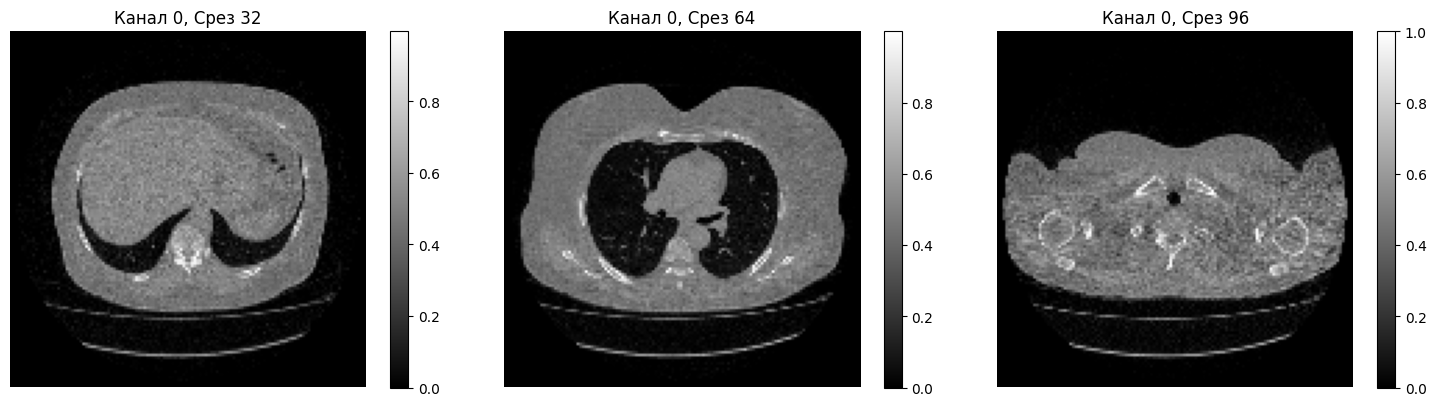

In [29]:
assessor.visualize_all_channels(tensor)

Original shape: (344, 512, 512)
Processed shape: (128, 128, 128)


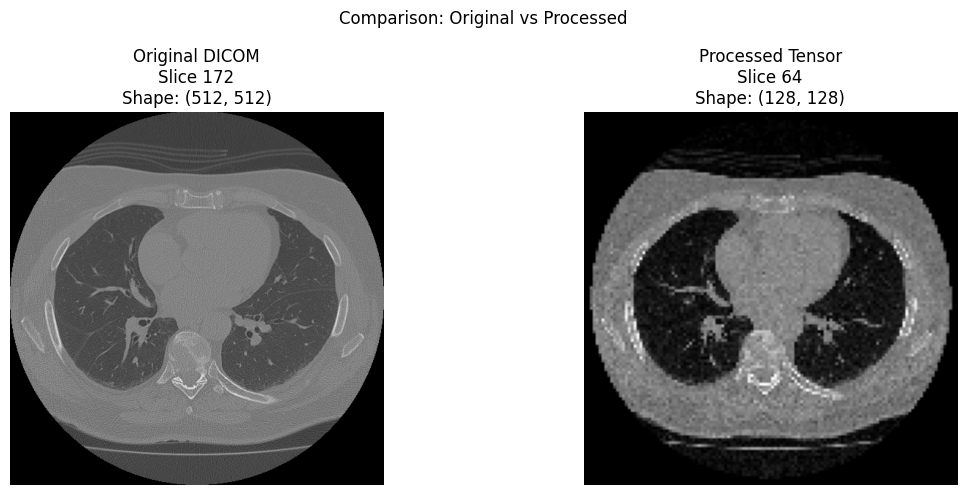

In [5]:
compare_volumes("../data/processed/train/04", "data/train/tensors/04.pt")

In [30]:
# Загрузка тензора
tensor = torch.load("data/train/tensors/02.pt")

# Просмотр размера
print(f"Форма тензора: {tensor.shape}")
print(f"Размерности: {tensor.dim()}")
print(f"Тип данных: {tensor.dtype}")
print(f"Устройство: {tensor.device}")

# Полная информация
print(f"Полная информация: {tensor}")

Форма тензора: torch.Size([1, 1, 128, 128, 128])
Размерности: 5
Тип данных: torch.float32
Устройство: cpu
Полная информация: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0

# Разделение на трейн и тест

In [2]:
split_dataset()

Dataset split completed!
Train samples: 4
Test samples: 2
Train class distribution:
label
0    2
1    2
Name: count, dtype: int64
Test class distribution:
label
0    1
1    1
Name: count, dtype: int64


(  filename  label
 1    02.pt      0
 5    06.pt      1
 0    01.pt      0
 4    05.pt      1,
   filename  label
 3    04.pt      1
 2    03.pt      0)

In [17]:
!python MedicalNet/main.py \
    model=resnet \
    model_depth=10 \
    input_W=160 \
    input_H=160 \
    input_D=128 \
    batch_size=2 \
    learning_rate=0.0001 \
    n_epochs=50 \
    data_root="data/train/tensors" \
    img_list="data/train/labels.csv" \
    no_cuda=true

loading pretrained model MedicalNet/pretrain/resnet_18.pth
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 14.4 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.602    Total estimated model params size (MB)


# Создание датасета